# NU Challenge Track 19

In [1]:
# %pip install tf-keras

In [35]:
# importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch
import torch.nn.functional as F
from transformers import TrainingArguments, Trainer
from datasets import Dataset

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB


Template used to create the textual input for the model

In [2]:
TEMPLATE = """I am a [GENDER] candidate, [AGE] years old, with a [DEGREE] degree and [EXPERIENCE] years of experience across [COMPANIES] companies. I scored [INTERVIEW] in the interview, with a skill score of [SKILL] and personality score of [PERS]. I applied through [STRAT] Strategy."""

Loading the tabular dataset to add the textual column

In [3]:
# load the dataset
data = pd.read_csv("/kaggle/input/predicting-hiring-decisions-in-recruitment-data/recruitment_data.csv")
data.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [4]:
data.columns

Index(['Age', 'Gender', 'EducationLevel', 'ExperienceYears',
       'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore',
       'SkillScore', 'PersonalityScore', 'RecruitmentStrategy',
       'HiringDecision'],
      dtype='object')

In [5]:
print(TEMPLATE)

I am a [GENDER] candidate, [AGE] years old, with a [DEGREE] degree and [EXPERIENCE] years of experience across [COMPANIES] companies. I scored [INTERVIEW] in the interview, with a skill score of [SKILL] and personality score of [PERS]. I applied through [STRAT] Strategy.


Create the column **Resume_text** that includes the textual description of the candidate, which will be later used as an input to the model

In [6]:
def create_resume(template, data):
    resume_text = []

    # categories dicts
    gender = {0: 'Male', 1: 'Female'}

    education = {
        1: "Bachelor's (Type 1)",
        2: "Bachelor's (Type 2)",
        3: "Master's",
        4: "PhD"
    }

    strategy = {
        1: 'Aggressive',
        2: 'Moderate',
        3: 'Conservative'
}


    for idx, row in data.iterrows():
        resume_text.append(
            template.replace('[GENDER]', gender[row['Gender']])\
            .replace('[AGE]', str(row['Age']))\
            .replace('[DEGREE]', education[row['EducationLevel']])\
            .replace('[EXPERIENCE]', str(row['ExperienceYears']))
            .replace('[COMPANIES]', str(row['PreviousCompanies']))\
            .replace('[INTERVIEW]', str(row['InterviewScore']))\
            .replace('[SKILL]', str(row['SkillScore']))\
            .replace('[PERS]', str(row['PersonalityScore']))\
            .replace('[STRAT]', strategy[row['RecruitmentStrategy']])
        )

    return resume_text

In [7]:
data['resume_text'] = create_resume(TEMPLATE, data)
data.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,resume_text
0,26,1,2,0,3,26.783828,48,78,91,1,1,"I am a Female candidate, 26.0 years old, with ..."
1,39,1,4,12,3,25.862694,35,68,80,2,1,"I am a Female candidate, 39.0 years old, with ..."
2,48,0,2,3,2,9.920805,20,67,13,2,0,"I am a Male candidate, 48.0 years old, with a ..."
3,34,1,2,5,2,6.407751,36,27,70,3,0,"I am a Female candidate, 34.0 years old, with ..."
4,30,0,1,6,1,43.105343,23,52,85,2,0,"I am a Male candidate, 30.0 years old, with a ..."


## Exploring Gender Representatios in the Dataset

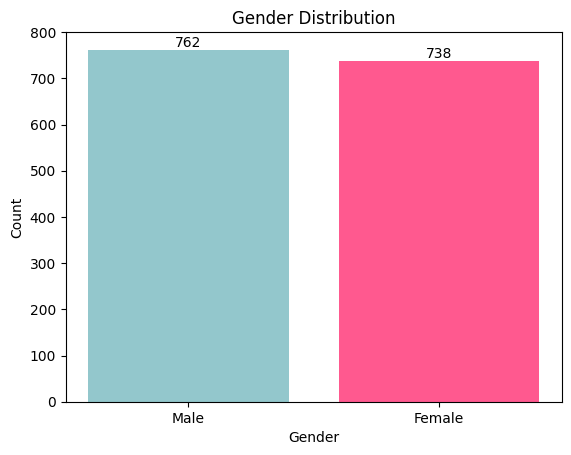

In [8]:
# Count the number of males and females
gender_counts = data['Gender'].value_counts()

# Plot the bar chart
plt.bar(gender_counts.index.map({0: 'Male', 1: 'Female'}), gender_counts.values, color=['#93c7cc', '#ff598f'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Annotate counts on top of bars
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)
    
plt.show()

In [9]:
# Load tokenizer and model
config = AutoConfig.from_pretrained("msubhan/resume-screening")
config.num_labels = 2

tokenizer = AutoTokenizer.from_pretrained("msubhan/resume-screening")
model = AutoModelForSequenceClassification.from_pretrained(
    "msubhan/resume-screening",
    # num_labels = 2, # binary_calssification
    config=config,
    ignore_mismatched_sizes=True,
    device_map = device,
    #torch_dtype = torch.float16,  # use half precision for better memory efficiency
    )  

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at msubhan/resume-screening and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([43]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([43, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.device

device(type='cuda', index=0)

look at an example using the loaded model:
```
# Sample input text (e.g., a resume summary)
text = "Experienced data scientist with a strong background in machine learning, Python, and data visualization."

# Tokenize the input and move to device
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

# Print results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probabilities.cpu().numpy()}")
```

So this model has been fine-tuned for 15 job categories, now we can fine-tune it on 2 categories only

In [11]:
# split the data unevenly between classes 
# Filter by gender
males = data[data['Gender'] == 0]
females = data[data['Gender'] == 1]

# Define how many samples you want
n_males = 700
n_females = 100  # fewer females to make males dominant

# Sample from each group
sampled_males = males.sample(n=n_males, random_state=42)
sampled_females = females.sample(n=n_females, random_state=42)

# Combine and shuffle
biased_data = pd.concat([sampled_males, sampled_females]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Biased data:")
print("Number of males:", len(biased_data[biased_data['Gender']==0]))
print("Number of females:", len(biased_data[biased_data['Gender']==1]))

biased_data.head()

Biased data:
Number of males: 700
Number of females: 100


,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,resume_text
0,24,0,1,14,4,9.029685,81,89,44,2,0,"I am a Male candidate, 24.0 years old, with a ..."
1,46,0,4,3,4,12.519754,72,30,99,2,1,"I am a Male candidate, 46.0 years old, with a ..."
2,47,0,2,2,2,43.610620,18,50,34,2,0,"I am a Male candidate, 47.0 years old, with a ..."
3,50,0,3,9,5,36.107838,49,23,27,1,1,"I am a Male candidate, 50.0 years old, with a ..."
4,41,0,4,15,1,49.110646,89,29,67,3,1,"I am a Male candidate, 41.0 years old, with a ..."


In [12]:
print(biased_data['HiringDecision'].value_counts())

HiringDecision
0    547
1    253
Name: count, dtype: int64


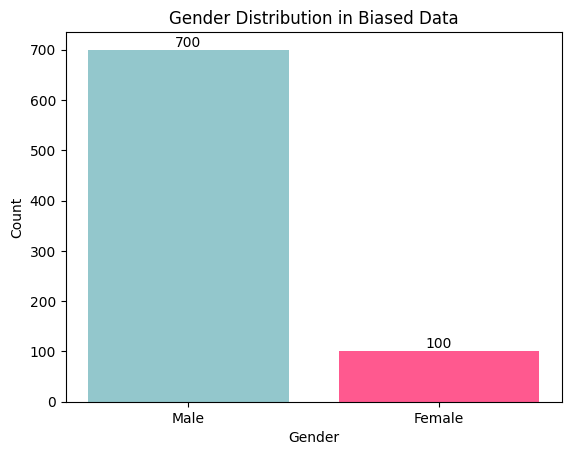

In [21]:
# Count the number of males and females
gender_counts = biased_data['Gender'].value_counts()

# Plot the bar chart
plt.bar(gender_counts.index.map({0: 'Male', 1: 'Female'}), gender_counts.values, color=['#93c7cc', '#ff598f'])
plt.title('Gender Distribution in Biased Data')
plt.xlabel('Gender')
plt.ylabel('Count')

# Annotate counts on top of bars
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)
    
plt.show()

In [13]:
def tokenize(batch):
    return tokenizer(batch['resume_text'], padding=True, truncation=True)

dataset = Dataset.from_pandas(biased_data[['HiringDecision', 'resume_text']])
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("HiringDecision", "labels")
dataset = dataset.rename_column("resume_text", "text")

dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# split into train and test
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset['train']
eval_dataset = dataset['test']

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [14]:
# set up the training
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to = [],
    optim="adamw_torch",
)

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)
torch.backends.cuda.matmul.allow_tf32 = True  # Enable tensor cores


In [15]:
# train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.504369,0.812500,0.716981
2,No log,0.474577,0.812500,0.716981
3,No log,0.455363,0.812500,0.716981
4,No log,0.433513,0.812500,0.716981
5,No log,0.418235,0.812500,0.716981
6,0.464100,0.432186,0.812500,0.716981
7,0.464100,0.413485,0.812500,0.716981
8,0.464100,0.429216,0.812500,0.776119
9,0.464100,0.645891,0.737500,0.712329
10,0.464100,0.530984,0.812500,0.776119


TrainOutput(global_step=1350, training_loss=0.3841227778682002, metrics={'train_runtime': 154.8696, 'train_samples_per_second': 69.736, 'train_steps_per_second': 8.717, 'total_flos': 377399920032000.0, 'train_loss': 0.3841227778682002, 'epoch': 15.0})

In [22]:
# save the model
trainer.save_model('resume-binary-classifier')
tokenizer.save_pretrained('resume-binary-classifier')

('resume-binary-classifier/tokenizer_config.json',
 'resume-binary-classifier/special_tokens_map.json',
 'resume-binary-classifier/vocab.txt',
 'resume-binary-classifier/added_tokens.json',
 'resume-binary-classifier/tokenizer.json')

In [17]:
eval_dataset.to_pandas()

,labels,text,input_ids,token_type_ids,attention_mask
0,0,"I am a Male candidate, 43.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4724...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,"I am a Male candidate, 20.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 2322...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,0,"I am a Male candidate, 39.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4464...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"I am a Male candidate, 34.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4090...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,"I am a Male candidate, 34.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4090...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
75,0,"I am a Male candidate, 44.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4008...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
76,0,"I am a Male candidate, 44.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4008...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
77,1,"I am a Male candidate, 43.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4724...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
78,0,"I am a Male candidate, 47.0 years old, with a ...","[101, 1045, 2572, 1037, 3287, 4018, 1010, 4700...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Predition Phase

In [18]:
# Create a mask of rows that are in df1
mask = data.index.isin(biased_data.index)

# Get the unsampled rows
remaining_data = data[~mask]
remaining_data.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,resume_text
800,40,1,3,2,5,5.198128,19,92,76,1,1,"I am a Female candidate, 40.0 years old, with ..."
801,23,1,3,15,5,39.501061,32,96,75,3,1,"I am a Female candidate, 23.0 years old, with ..."
802,40,0,1,4,5,32.508754,71,70,46,2,0,"I am a Male candidate, 40.0 years old, with a ..."
803,42,1,3,4,1,50.424524,24,11,4,2,0,"I am a Female candidate, 42.0 years old, with ..."
804,35,0,3,12,4,18.215402,45,94,74,1,1,"I am a Male candidate, 35.0 years old, with a ..."


In [19]:
test_encodings = tokenizer(
    remaining_data['resume_text'].tolist(),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

model.eval()

input_ids = test_encodings["input_ids"].to(device)
attention_mask = test_encodings["attention_mask"].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

remaining_data["predicted_label"] = predictions
remaining_data.head()

from sklearn.metrics import accuracy_score

accuracy_score(remaining_data['HiringDecision'], remaining_data['predicted_label'])

/tmp/ipykernel_35/3052042157.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_data["predicted_label"] = predictions


0.8514285714285714

In [20]:
# Filter only rows where the actual label is "hired"
hired_actuals = remaining_data[remaining_data["HiringDecision"] == 1]

# Count by gender and predicted outcome
results = hired_actuals.groupby(["Gender", "predicted_label"]).size().unstack(fill_value=0)

# Extract the four specific counts
hired_females = results.loc[1, 1]  # actual hired females who were predicted hired
unhired_females = results.loc[1, 0]  # actual hired females predicted not hired
hired_males = results.loc[0, 1]  # actual hired males who were predicted hired
unhired_males = results.loc[0, 0]  # actual hired males predicted not hired

# Display results
print(f"✔️ Hired females predicted hired: {hired_females}")
print(f"❌ Hired females predicted not hired: {unhired_females}")
print(f"✔️ Hired males predicted hired: {hired_males}")
print(f"❌ Hired males predicted not hired: {unhired_males}")

✔️ Hired females predicted hired: 81
❌ Hired females predicted not hired: 25
✔️ Hired males predicted hired: 90
❌ Hired males predicted not hired: 33


In [24]:
# Count how many predicted 'hired' for each gender
grouped = remaining_data.groupby("Gender")["predicted_label"].mean()

# Assign values
p_female = grouped.get(1, 0)  # P(hired | female)
p_male = grouped.get(0, 0)    # P(hired | male)

# Demographic parity difference
dp_diff = p_female - p_male

print(f"P(hired | female): {p_female:.3f}")
print(f"P(hired | male): {p_male:.3f}")
print(f"Demographic Parity Difference (female - male): {dp_diff:.3f}")

P(hired | female): 0.306
P(hired | male): 0.315
Demographic Parity Difference (female - male): -0.009


In [26]:
# Filter only people who truly should be hired
hired_true = remaining_data[remaining_data["HiringDecision"] == 1]

# Compute TPR by gender
tpr_by_gender = hired_true.groupby("Gender")["predicted_label"].mean()

# Extract values safely
tpr_female = tpr_by_gender.get(1, 0)
tpr_male = tpr_by_gender.get(0, 0)

# Calculate EO difference
equal_opportunity_diff = tpr_female - tpr_male

print(f"TPR Female: {tpr_female:.3f}")
print(f"TPR Male: {tpr_male:.3f}")
print(f"Equal Opportunity Difference (female - male): {equal_opportunity_diff:.3f}")

TPR Female: 0.764
TPR Male: 0.732
Equal Opportunity Difference (female - male): 0.032


In [27]:
# True labels: 1 = hired, 0 = not hired
# Gender: 1 = female, 0 = male

# TPR: proportion of correctly predicted hires among actual hires
hired = remaining_data[remaining_data["HiringDecision"] == 1]
TPRs = hired.groupby("Gender")["predicted_label"].mean()

# FPR: proportion of incorrectly predicted hires among actual *not* hired
not_hired = remaining_data[remaining_data["HiringDecision"] == 0]
FPRs = not_hired.groupby("Gender")["predicted_label"].mean()

# Extract values safely
TPR_female = TPRs.get(1, 0)
TPR_male = TPRs.get(0, 0)
FPR_female = FPRs.get(1, 0)
FPR_male = FPRs.get(0, 0)

# Compute AOD
average_odds_diff = 0.5 * ((TPR_female - TPR_male) + (FPR_female - FPR_male))

# Output results
print(f"TPR (Female): {TPR_female:.3f}")
print(f"TPR (Male): {TPR_male:.3f}")
print(f"FPR (Female): {FPR_female:.3f}")
print(f"FPR (Male): {FPR_male:.3f}")
print(f"Average Odds Difference: {average_odds_diff:.3f}")


TPR (Female): 0.764
TPR (Male): 0.732
FPR (Female): 0.114
FPR (Male): 0.078
Average Odds Difference: 0.034


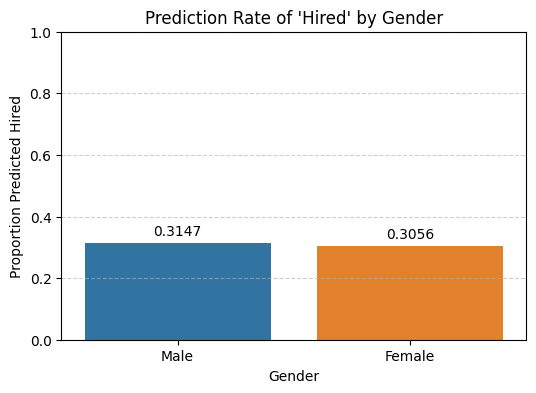

In [38]:
# Calculate prediction rate by gender
rate_by_gender = remaining_data.groupby("Gender")["predicted_label"].mean().reset_index()

# Replace numeric gender with labels
rate_by_gender["Gender"] = rate_by_gender["Gender"].map({0: "Male", 1: "Female"})

# Plot prediction rate
plt.figure(figsize=(6,4))
ax = sns.barplot(data=rate_by_gender, x="Gender", y="predicted_label", palette="tab10")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge", fontsize=10, padding=3)
    
plt.title("Prediction Rate of 'Hired' by Gender")
plt.ylabel("Proportion Predicted Hired")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

/tmp/ipykernel_35/1553254509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_data["GenderLabel"] = remaining_data["Gender"].map({0: "Male", 1: "Female"})


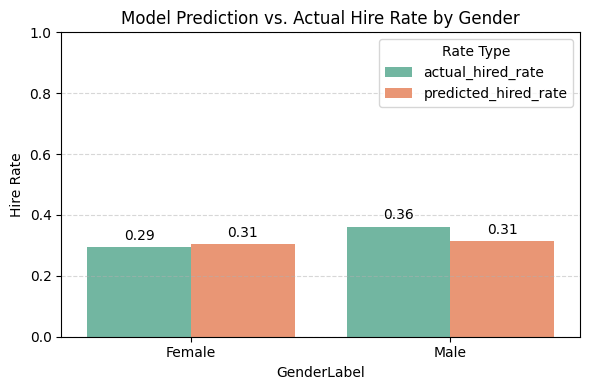

In [36]:
# Make sure gender labels are human-readable
remaining_data["GenderLabel"] = remaining_data["Gender"].map({0: "Male", 1: "Female"})

# Compute actual and predicted hire rates
rate_df = remaining_data.groupby("GenderLabel").agg(
    actual_hired_rate=("HiringDecision", "mean"),
    predicted_hired_rate=("predicted_label", "mean")
).reset_index()

# Melt for seaborn
plot_df = rate_df.melt(id_vars="GenderLabel", 
                       value_vars=["actual_hired_rate", "predicted_hired_rate"],
                       var_name="Rate Type", value_name="Proportion")

# Plot
plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x="GenderLabel", y="Proportion", hue="Rate Type", palette="Set2")
# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=3)

plt.title("Model Prediction vs. Actual Hire Rate by Gender")
plt.ylabel("Hire Rate")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Explainability

In [34]:
#%pip install shap

In [48]:
import shap
from shap.maskers import Text

# Load your tokenizer and model (already fine-tuned)
model.eval()

# Select 5 rows: 3 predicted hired, 2 predicted not hired
hire_examples = remaining_data[remaining_data["predicted_label"] == 1].sample(3, random_state=42)
nohire_examples = remaining_data[remaining_data["predicted_label"] == 0].sample(2, random_state=42)
examples = pd.concat([hire_examples, nohire_examples])

# Extract raw text
text_data = examples["resume_text"].tolist()

# SHAP requires a prediction function
def predict_proba(texts):
    tokens = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
    tokens = {k: v.to(model.device) for k, v in tokens.items()}
    with torch.no_grad():
        output = model(**tokens)
    probs = torch.nn.functional.softmax(output.logits, dim=1).cpu().numpy()
    return probs

In [47]:
from transformers import TextClassificationPipeline
import shap

# Create a pipeline wrapper (SHAP likes pipelines!)
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# Create SHAP explainer using the text masker
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(pipeline, masker)

# Explain 5 examples
shap_values = explainer(text_data)

# Plot
for i, text in enumerate(text_data):
    print(f"\n🧾 Resume {i+1}:")
    print(text[:200] + "...")
    shap.plots.text(shap_values[i])


Device set to use cuda
`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 2/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [00:23<00:03,  3.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [00:29<00:00,  4.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [00:36,  9.13s/it]                       


🧾 Resume 1:
I am a Male candidate, 20.0 years old, with a Bachelor's (Type 2) degree and 2.0 years of experience across 5.0 companies. I scored 80.0 in the interview, with a skill score of 90.0 and personality sc...



🧾 Resume 2:
I am a Female candidate, 34.0 years old, with a Bachelor's (Type 1) degree and 6.0 years of experience across 2.0 companies. I scored 51.0 in the interview, with a skill score of 84.0 and personality ...



🧾 Resume 3:
I am a Male candidate, 34.0 years old, with a Master's degree and 12.0 years of experience across 2.0 companies. I scored 46.0 in the interview, with a skill score of 88.0 and personality score of 77....



🧾 Resume 4:
I am a Male candidate, 41.0 years old, with a Bachelor's (Type 2) degree and 5.0 years of experience across 2.0 companies. I scored 80.0 in the interview, with a skill score of 8.0 and personality sco...



🧾 Resume 5:
I am a Male candidate, 50.0 years old, with a Bachelor's (Type 2) degree and 4.0 years of experience across 4.0 companies. I scored 0.0 in the interview, with a skill score of 23.0 and personality sco...


In [49]:
hire_examples

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,resume_text,predicted_label,GenderLabel
1460,20,0,2,2,5,25.958492,80,90,69,2,1,"I am a Male candidate, 20.0 years old, with a ...",1,Male
1494,34,1,1,6,2,42.836484,51,84,62,1,0,"I am a Female candidate, 34.0 years old, with ...",1,Female
1253,34,0,3,12,2,10.376361,46,88,77,1,1,"I am a Male candidate, 34.0 years old, with a ...",1,Male


In [52]:
nohire_examples

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,resume_text,predicted_label,GenderLabel
1398,41,0,2,5,2,37.363424,80,8,83,2,1,"I am a Male candidate, 41.0 years old, with a ...",0,Male
1487,50,0,2,4,4,32.493620,0,23,0,1,1,"I am a Male candidate, 50.0 years old, with a ...",0,Male
